In [1]:
import torch
import torch.nn as nn
import random
import seaborn as sns
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head(20)

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
flight_data["passengers"] = scaler.fit_transform(
    flight_data["passengers"].values.reshape(-1, 1)
).flatten()

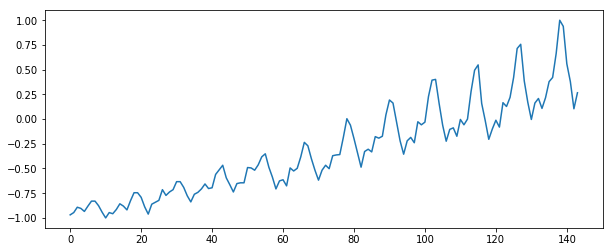

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(flight_data["passengers"])

In [6]:
def lag_with_pct_change(df, windows):
    train_cols = []
    for window in reversed(windows):
        df["shift_pos_" + str(window)] = df["passengers"].shift(window).fillna(0)
        train_cols.append("shift_pos_" + str(window))
    return df[len(windows) :], train_cols

In [7]:
df, train_cols = lag_with_pct_change(flight_data, range(1, 13))
df["group"] = df.groupby(df.index // 6, sort=False)["passengers"].agg(["ngroup"])
test_cols = ["passengers"]
df

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,month,passengers,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,shift_pos_8,shift_pos_7,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1,group
12,1950,January,-0.957529,-0.969112,-0.945946,-0.891892,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,0
13,1950,February,-0.915058,-0.945946,-0.891892,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,0
14,1950,March,-0.857143,-0.891892,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,-0.915058,0
15,1950,April,-0.880309,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,-0.915058,-0.857143,0
16,1950,May,-0.918919,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,-0.915058,-0.857143,-0.880309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960,August,0.938224,0.756757,0.386100,0.169884,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,21
140,1960,September,0.559846,0.386100,0.169884,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,0.938224,21
141,1960,October,0.378378,0.169884,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,0.938224,0.559846,21
142,1960,November,0.104247,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,0.938224,0.559846,0.378378,21


In [8]:
train_df = df.iloc[:-12, :]
test_df = df.iloc[-12:, :]
train_df.shape, test_df.shape

((120, 16), (12, 16))

In [9]:
X_train = np.array(
    list(train_df.groupby("group").apply(lambda x: x[train_cols].values))
).astype(np.float32)
y_train = np.array(
    list(train_df.groupby("group").apply(lambda x: x[test_cols].values))
).astype(np.float32)
X_train.shape, y_train.shape

((20, 6, 12), (20, 6, 1))

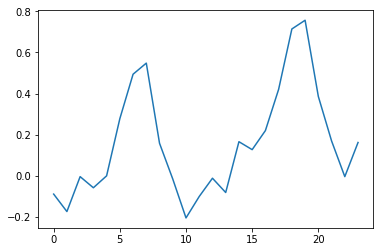

In [10]:
plt.plot(y_train[-4:].flatten())

In [11]:
class DS(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        data = self.X_train[idx, :]
        labels = self.y_train[idx, :]
        return data, labels

In [12]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        input_size = input_size

        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False,
        )
        self.lstm2 = nn.LSTM(
            hidden_size,
            hidden_size * 2,
            num_layers=1,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = self.fc(x)

        return x

In [13]:
db = DataBunch.create(DS(X_train, y_train), valid_ds=None, bs=8)

In [14]:
db

DataBunch;

Train: <__main__.DS object at 0x7f879c0348d0>;

Valid: <__main__.DS object at 0x7f879c0348d0>;

Test: None

In [15]:
model = Model(input_size=len(train_cols))

In [16]:
learn = Learner(db, model, loss_func=nn.MSELoss(),callback_fns = [ShowGraph, ])

epoch,train_loss,valid_loss,time
0,0.256487,#na#,00:00
1,0.300845,#na#,00:00
2,0.289015,#na#,00:00
3,0.297131,#na#,00:00
4,0.288308,#na#,00:00
5,0.291432,#na#,00:00
6,0.302406,#na#,00:00
7,0.301343,#na#,00:00
8,0.301862,#na#,00:00
9,0.298231,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


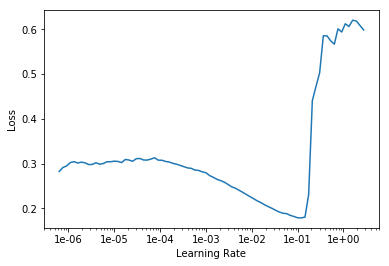

In [17]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.274690,0.282230,00:00
1,0.267694,0.257288,00:00
2,0.259306,0.231434,00:00
3,0.252825,0.203147,00:00
4,0.236791,0.172577,00:00
5,0.227865,0.139186,00:00
6,0.212453,0.113823,00:00
7,0.200136,0.126919,00:00
8,0.190228,0.135925,00:00
9,0.182874,0.105909,00:00


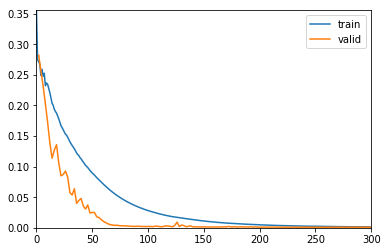

In [18]:
learn.fit_one_cycle(150, max_lr = 1e-2,wd = 10e-4)

In [28]:
fut_pred = 50
train_window = len(train_cols)
test_inputs = X_train[-1, -1, :].tolist()
model = model.cpu()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).view(1, 1, -1).float()
    with torch.no_grad():
        test_inputs.append(model(seq).item())

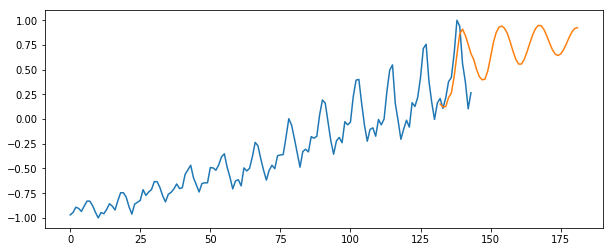

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(flight_data['passengers'])
plt.plot(np.arange(132, 132+fut_pred, 1), test_inputs[-fut_pred:])